In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler
import random
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#install to download the dataset easily
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [3]:
#download dataset
!gdown 18wEiRTNkFRp5Xlt1pvtw8q7Me_lENX21

Downloading...
From: https://drive.google.com/uc?id=18wEiRTNkFRp5Xlt1pvtw8q7Me_lENX21
To: /content/Dental.rar
100% 40.1M/40.1M [00:00<00:00, 146MB/s]


In [4]:
#unzip dataset
!unrar x "/content/Dental.rar" 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Dental.rar

Creating    Dental                                                    OK
Creating    Dental/Argon                                              OK
Extracting  Dental/Argon/1252.PNG                                          0%  OK 
Extracting  Dental/Argon/170861378_181773640455697_8868278685022032298_n_03.jpg       0%  OK 
Extracting  Dental/Argon/170997132_181773687122359_801184412197855815_n_03.jpg       0%  OK 
Extracting  Dental/Argon/172042944_181773760455685_5660686353046769448_n_03.jpg       0%  OK 
Extracting  Dental/Argon/2123.PNG                                          0%  OK 
Extracting  Dental/Argon/215339849_1394213794283356_2287391585413002973_n_03.jpg       0%  OK 
Extracting  Dental/Argon/215339849_1394213794283356_2287391585413002973_n_06.jpg       0%  OK 
Extracting  Dental/Argon/215339849_1394213794283

In [5]:

import os
import random
from PIL import Image

In [6]:
# Split the "Dental" images folder into Training Iamges and Testing Images folders

os.mkdir("./train_images")    
os.mkdir("./test_images")

source = "./Dental"

for file in os.listdir(source):
    
    images = os.listdir(os.path.join(source, file))
    n_images = len(images)
    if n_images < 25 : 
        continue
        
    size_test = int(0.1*n_images)
    test_images = random.sample(images, size_test)
    train_images = images.copy()
    for image in test_images:
        train_images.remove(image)
        
    os.mkdir(os.path.join("./train_images", file))
    os.mkdir(os.path.join("./test_images", file))
    

    for image in train_images:
        im = Image.open(os.path.join(source, file, image))
        rgb_im = im.convert('RGB')
        rgb_im.save(os.path.join("./train_images", file, image))
        
    for image in test_images:
        im = Image.open(os.path.join(source, file, image))
        rgb_im = im.convert('RGB')
        rgb_im.save(os.path.join("./test_images", file, image))
        

In [7]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
# choose the training and test datasets
train_data = datasets.ImageFolder("./train_images",
                                  transform=train_transforms)
test_data = datasets.ImageFolder("./test_images",
                                 transform=test_transforms)
classes = train_data.classes
# obtain training indices that will be used for validation
validation_ratio = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_ratio * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
batch_size = 6
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

loaders = {'train': train_loader, 'valid': valid_loader,
                   'test': test_loader}

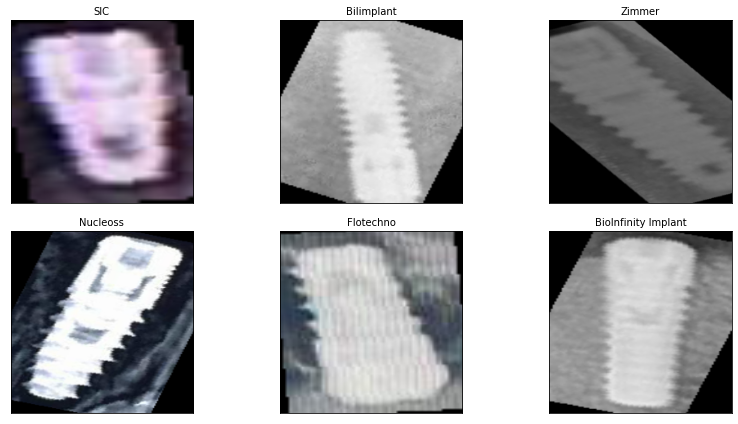

In [8]:
# obtain one batch of training images
images, labels = next(iter(loaders["train"]))
images = images.numpy() 

# plot images from the batch, along with the corresponding labels
fig = plt.figure(figsize=(12, 6))
for idx in np.arange(batch_size):
    img = images[idx] / 2 + 0.5  # unnormalize
    label = labels[idx]
    ax = fig.add_subplot(2, int(np.ceil(batch_size/2)), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(classes[label], fontsize = 10)
fig.tight_layout()

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    training_losses = []
    validation_losses = []
    
    for epoch in range(1, n_epochs+1):

        ###################
        # train the model #
        ###################
        # set the module to training mode
        train_loss = 0.0
        counter = 0
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss =  criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            counter += 1
            
        train_loss = train_loss / counter
        training_losses.append(train_loss)
        torch.cuda.empty_cache()
        

        ######################    
        # validate the model #
        ######################
        valid_loss = 0.0
        valid_acc = 0.0
        total = 0
        counter = 0
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):

                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)

                # Calculate the patch mean loss
                loss =  criterion(output, target)

                # Accumulate the batch loss to the total validation loss
                valid_loss += loss.item()
                
                # Get the probabilities of each class for each image in the patch
                output = F.softmax(output, dim = 1)
                
                # Get the labels of the predicted classes (the class with the highest probability) for each image in patch
                _, pred = torch.max(output, 1)
                
                # Get the probabilities of each class for each image in the patch
                correct_tensor = pred.eq(target.data.view_as(pred)).int()
                
                # Add the number of correctly predicted images in the batch
                valid_acc += torch.sum(correct_tensor.type(torch.FloatTensor))

                # Increment the total number of patches so far
                counter += 1

                # Add the patch size to total number of images so far
                total += len(target)
                
            valid_acc = (valid_acc / total) * 100
            valid_loss = valid_loss / counter
            validation_losses.append(valid_loss)
            torch.cuda.empty_cache()
            
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.3f}%'.format(
        epoch, train_loss, valid_loss, valid_acc))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model, training_losses, validation_losses

In [10]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0
    counter = 0
    # set the module to evaluation mode
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # Calculate the patch mean loss
            loss = criterion(output, target)

            # Accumulate the batch loss to the total test loss
            test_loss += loss.item()

            # Get the probabilities of each class for each image in the patch
            output = F.softmax(output, dim = 1)
            
            # Get the labels of the predicted classes (the class with the highest probability) for each image in patch
            _, pred = torch.max(output, 1)
            
            # Get the probabilities of each class for each image in the patch
            correct_tensor = pred.eq(target.data.view_as(pred)).int()
            
            # Add the number of correctly predicted images in the batch
            correct += torch.sum(correct_tensor.type(torch.FloatTensor))

            # Increment the total number of patches so far
            counter += 1 

            # Add the patch size to total number of images so far
            total += len(target)
            
    print('Test Loss: {:.6f}\n'.format(test_loss/counter))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [11]:
def custom_weight_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [12]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [13]:
VGG_model =  models.vgg16(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [14]:
VGG_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
VGG_model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(1000, len(classes))
)

In [16]:
# Freeze training for all "features" layers
for param in VGG_model.features.parameters():
    param.requires_grad = False

In [17]:
VGG_model.classifier.apply(custom_weight_init)

if use_cuda:
    VGG_model = VGG_model.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(VGG_model.parameters(), lr=0.01)    

VGG_model, training_losses, validation_losses = train(200, loaders, VGG_model, optimizer,
                      criterion, use_cuda, 'VGG_model.pt')

Epoch: 1 	Training Loss: 4.039233 	Validation Loss: 3.644395 	Validation Accuracy: 4.051%
Validation loss decreased (inf --> 3.644395).  Saving model ...
Epoch: 2 	Training Loss: 3.657793 	Validation Loss: 3.569048 	Validation Accuracy: 5.316%
Validation loss decreased (3.644395 --> 3.569048).  Saving model ...
Epoch: 3 	Training Loss: 3.523387 	Validation Loss: 3.448097 	Validation Accuracy: 10.127%
Validation loss decreased (3.569048 --> 3.448097).  Saving model ...
Epoch: 4 	Training Loss: 3.419915 	Validation Loss: 3.425106 	Validation Accuracy: 9.114%
Validation loss decreased (3.448097 --> 3.425106).  Saving model ...
Epoch: 5 	Training Loss: 3.347725 	Validation Loss: 3.328544 	Validation Accuracy: 14.684%
Validation loss decreased (3.425106 --> 3.328544).  Saving model ...
Epoch: 6 	Training Loss: 3.270500 	Validation Loss: 3.228074 	Validation Accuracy: 18.734%
Validation loss decreased (3.328544 --> 3.228074).  Saving model ...
Epoch: 7 	Training Loss: 3.216008 	Validation Lo

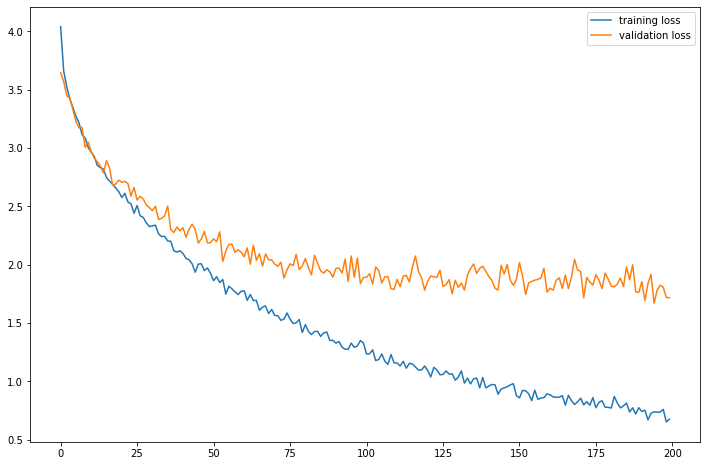

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(training_losses, label="training loss")
plt.plot(validation_losses, label="validation loss")
plt.legend()

In [19]:
# Test the model
test(loaders, VGG_model, criterion, use_cuda)

Test Loss: 2.108204


Test Accuracy: 54% (108/197)


In [20]:
torch.save(VGG_model.state_dict(), "/content/VGG_model.pt")